## Exploratory Data Analysis

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

aa62_data = np.load('data/AA66266AA.npy', allow_pickle=True)
aa64_data = np.load('data/AA66466AA.npy', allow_pickle=True)
aa65_data = np.load('data/AA66566AA.npy', allow_pickle=True)

In [137]:
def plot_data(data):
    k = len(data)
    fig, axes = plt.subplots(k, 1, figsize=(30, 15), sharex=True, sharey=True)

    for i in range(k):
        event = data[i]
        time = event[:, 0]
        current = event[:, 1]

        g = sns.lineplot(x=time, y=current, ax=axes[i])
        g.set_xlabel('Time [ms]')
        g.set_ylabel('Current')

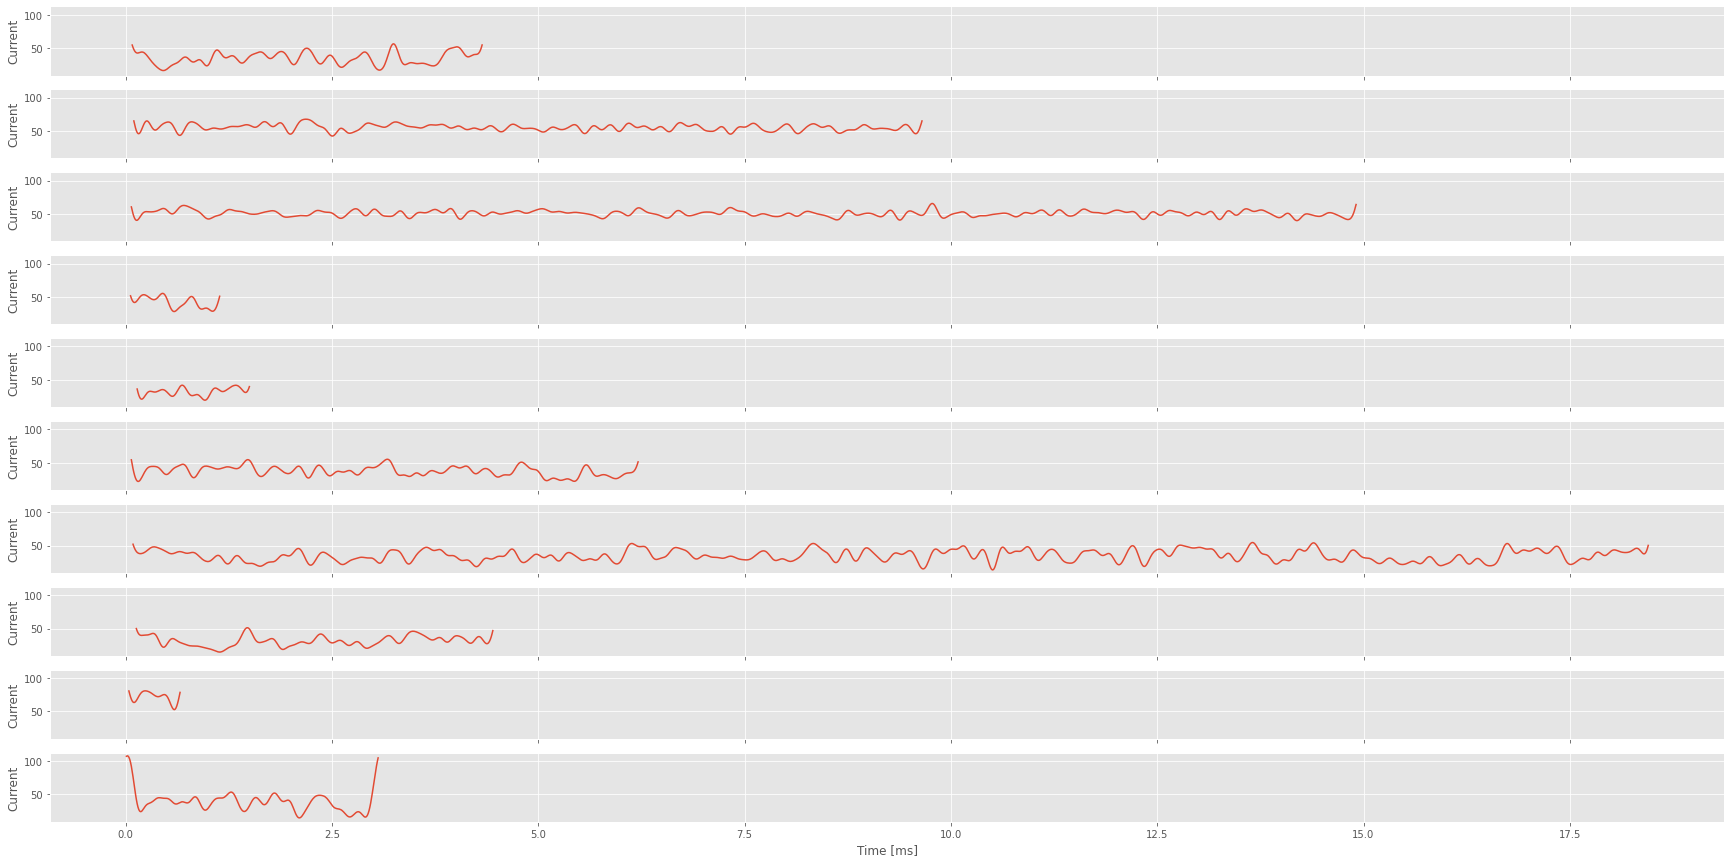

In [139]:
plot_data(aa62_data[:10])

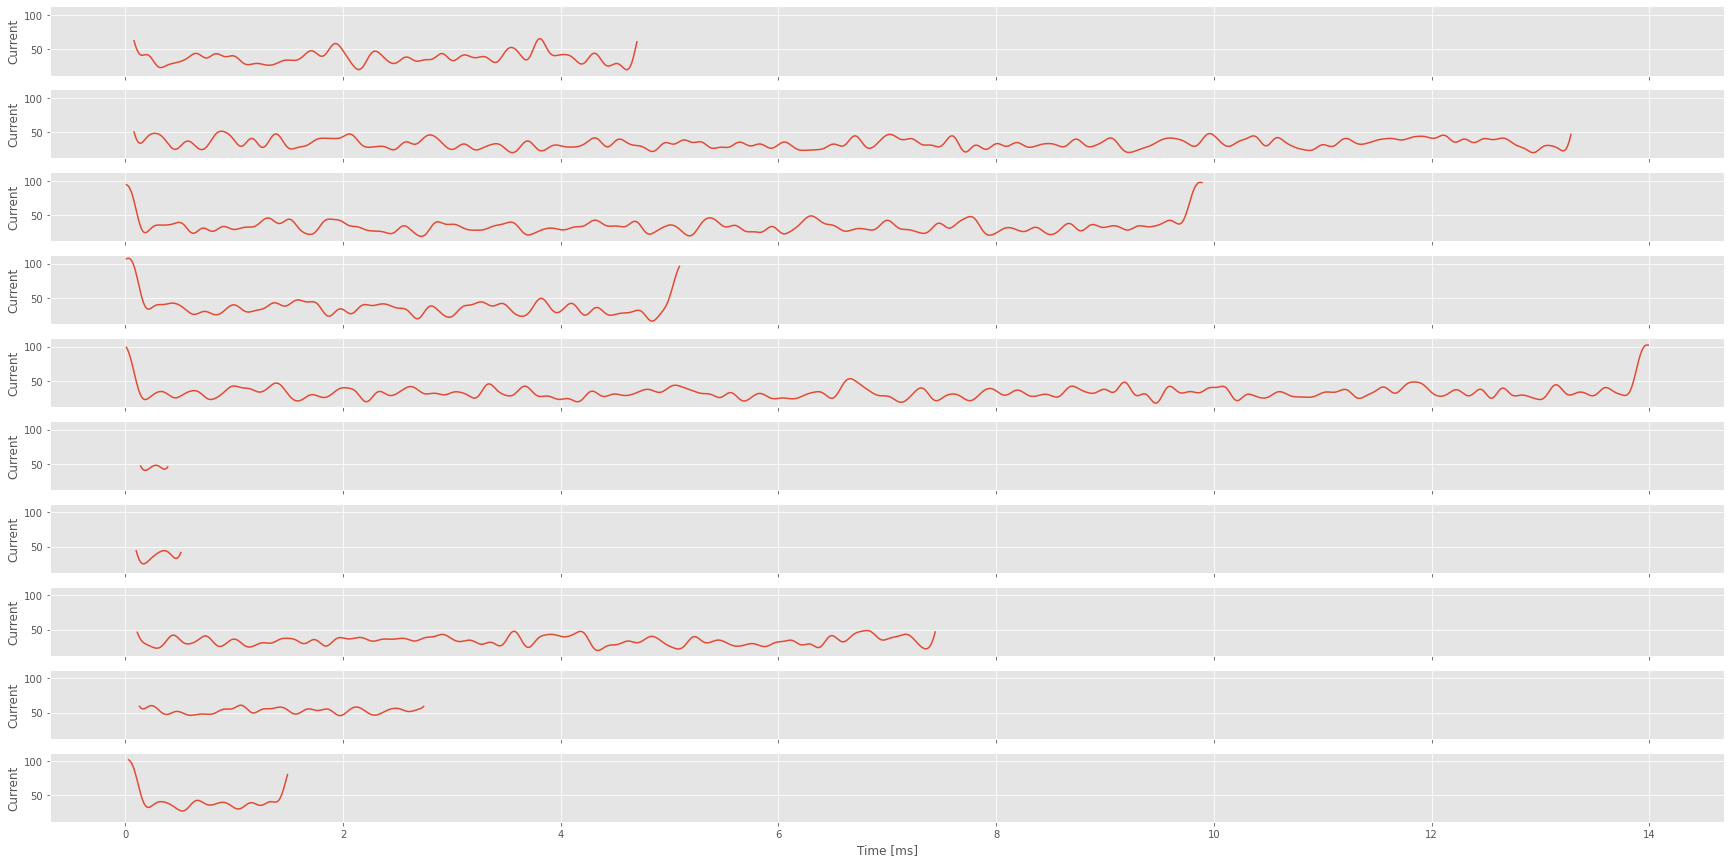

In [140]:
plot_data(aa64_data[:10])

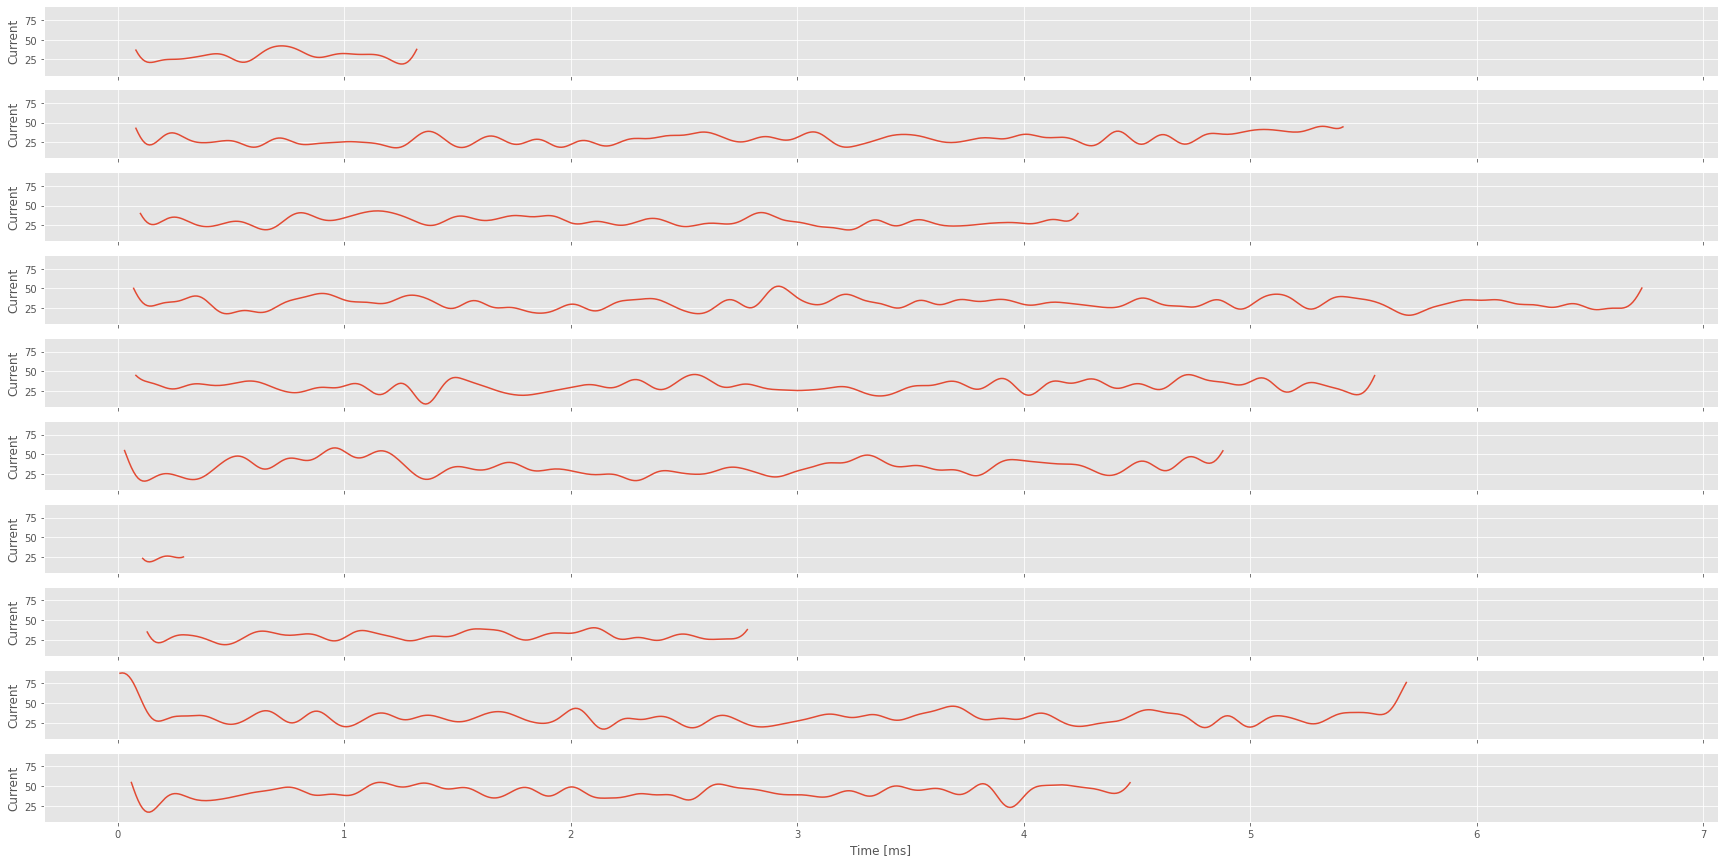

In [141]:
plot_data(aa65_data[:10])

In [164]:
aa62_event_lens = [len(event) for event in aa62_data]
aa64_event_lens = [len(event) for event in aa64_data]
aa65_event_lens = [len(event) for event in aa65_data]

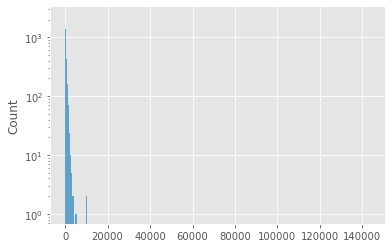

In [165]:
sns.histplot(aa62_event_lens)
plt.yscale('log')

In [170]:
(np.array(aa62_event_lens) > 5000).sum()

45

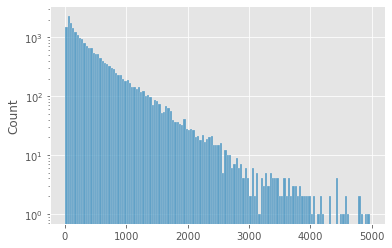

In [168]:
sns.histplot([event_len for event_len in aa62_event_lens if event_len <= 5000])
plt.yscale('log')

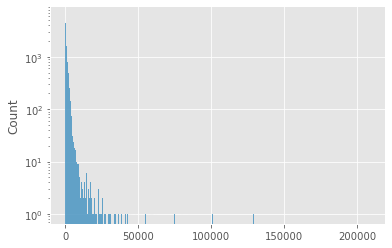

In [169]:
sns.histplot(aa64_event_lens)
plt.yscale('log')

In [175]:
(np.array(aa64_event_lens) > 50000).sum()

23

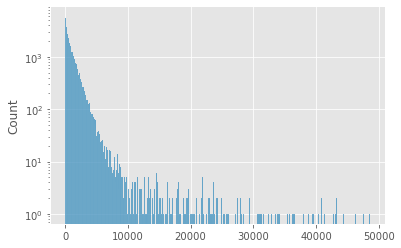

In [176]:
sns.histplot([event_len for event_len in aa64_event_lens if event_len <= 50000])
plt.yscale('log')

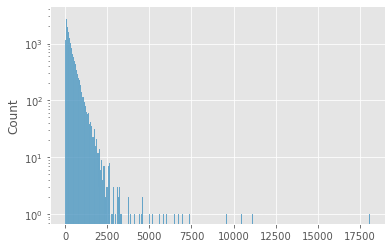

In [178]:
sns.histplot(aa65_event_lens)
plt.yscale('log')

In [180]:
(np.array(aa65_event_lens) > 5000).sum()

26

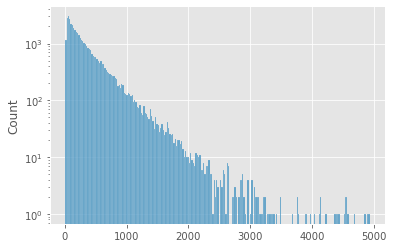

In [182]:
sns.histplot([event_len for event_len in aa65_event_lens if event_len <= 5000])
plt.yscale('log')

In [183]:
aa62_event_durations = [event[-1][0] for event in aa62_data]
aa64_event_durations = [event[-1][0] for event in aa64_data]
aa65_event_durations = [event[-1][0] for event in aa65_data]

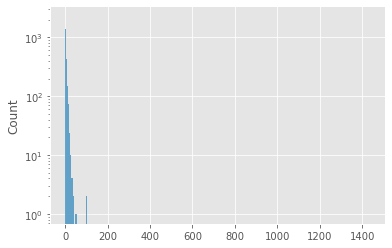

In [185]:
sns.histplot(aa62_event_durations)
plt.yscale('log')

In [187]:
(np.array(aa62_event_durations) > 200).sum()

5

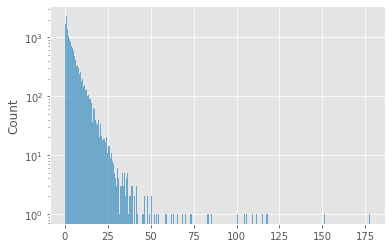

In [188]:
sns.histplot([event_d for event_d in aa62_event_durations if event_d <= 200])
plt.yscale('log')

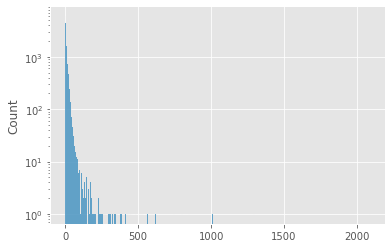

In [189]:
sns.histplot(aa64_event_durations)
plt.yscale('log')

In [190]:
(np.array(aa64_event_durations) > 500).sum()

23

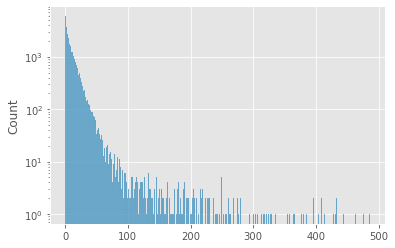

In [191]:
sns.histplot([event_d for event_d in aa64_event_durations if event_d <= 500])
plt.yscale('log')

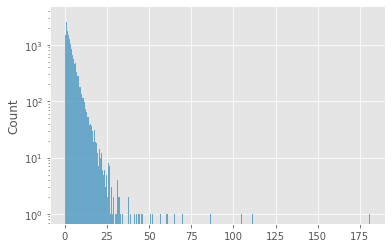

In [192]:
sns.histplot(aa65_event_durations)
plt.yscale('log')

In [194]:
(np.array(aa65_event_durations) > 100).sum()

7

In [ ]:
sns.histplot([event_d for event_d in aa64_event_durations if event_d <= 100])
plt.yscale('log')

## Modelling

In [123]:
import torch
from torch.utils.data import Dataset
import numpy as np

class PolymerDataset(Dataset):
    def __init__(self, data_paths, timesteps=100) -> None:
        self.raw_data = [np.load(data_path, allow_pickle=True) for data_path in data_paths]
        self.prepare(timesteps=timesteps)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
    def max_seq_len(self):
        return max([len(event) for event in self.data])
    
    def _process_event(self, event, timesteps):
        if len(event) >= timesteps:
            # long event
            compressed_event = []
            step_size = int(np.ceil(len(event) / timesteps))
            last_time = 0
            for i in range(timesteps):
                sub_event = event[i*step_size:(i+1)*step_size]
                if len(sub_event) > 0:
                    compressed_event.append(sub_event.mean(axis=0))
                    last_time = sub_event[-1][0]
                else:
                    compressed_event.append(np.array([last_time+0.01, 0]))
            return np.array(compressed_event)

        # short event
        paddings = []
        last_item = event[-1]
        for i in range(timesteps-len(event)):
            time = last_item[0] + (i+1) * 0.01
            paddings.append([time, 0])
        return np.vstack([event, paddings])
    
    def prepare(self, timesteps=100):
        data = []
        labels = []

        for data_index, raw_data in enumerate(self.raw_data):
            for event in raw_data:
                processed_event = self._process_event(event, timesteps=timesteps)
                data.append(processed_event)
                labels.append(data_index)

        self.data = torch.tensor(np.array(data), dtype=torch.float)
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        return self


In [132]:
dataset = PolymerDataset(['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy'], timesteps=1000)

In [133]:
dataset.data.shape, dataset.labels.shape

(torch.Size([140153, 1000, 2]), torch.Size([140153]))

In [134]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [135]:
class PolymerLSTM(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_size=32) -> None:
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=num_features, hidden_size=hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, num_classes)
    
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        outputs = lstm_out[:, -1, :]
        outputs = self.linear(outputs)
        probs = torch.nn.functional.log_softmax(outputs, dim=1)
        return probs

NUM_FEATURES = 2
NUM_CLASSES = 3
NUM_EPOCHS = 100
model = PolymerLSTM(NUM_FEATURES, NUM_CLASSES)
loss_function = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCHS):
    num_correct = 0
    for X, y in iter(data_loader):
        model.zero_grad()
        probs = model(X)
        loss = loss_function(probs, y)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(probs, dim=1, keepdim=False)
        num_correct += (preds == y).sum()
    print(f'epoch={epoch}/{NUM_EPOCHS}, loss={loss}, accuracy={num_correct*100/len(dataset)}')


KeyboardInterrupt: 

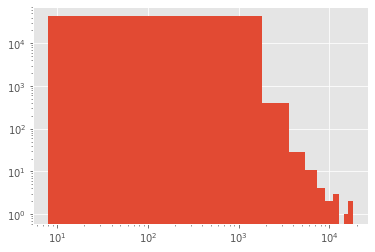

In [41]:
plt.hist(aa65_seq_lens)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [37]:
len(aa62_dataset.data)

22039

In [18]:
aa62_dataset.max_seq_len()

143487

In [26]:
aa62_dataset.prepare()

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/mismayil/opt/anaconda3/envs/ml/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1949, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/mismayil/opt/anaconda3/envs/ml/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1984, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 